# Transactions - Data Modelling

In [1]:
import os

import joblib
import pandas as pd
import numpy as np
import skops.io as sio

from helpers import (
    ENCODER_MODEL_DIR, FORECAST_MODEL_DIR, TRANSFORMED_DATA_DIR,
    cross_validation_with_pipeline
)

## Load integrated data

In [2]:
df_transactions = pd.read_parquet(TRANSFORMED_DATA_DIR / 'transactions_KL_ckpt7_integrated.parquet')
df_transactions.head()

,township,building_type,tenure,floors,rooms,land_area,built_up,price_psf,price,year,...,median_income,mean_income,n_households,wellbeing_index,money_supply_millions,unemployment_rate,population_thousands,n_crimes,date,interest_rate
34996,SENTOSA COURT,APARTMENT,LEASEHOLD,1.0,3.000000,1015.0,1015.0,128.0,129888.0,2000.0,...,3006.666667,4379.74,299566.666667,100.0,458363.1,3.0,1416.0,8770.0,2000-01-01,5.5
34997,SENTOSA COURT,APARTMENT,LEASEHOLD,1.0,3.000000,1007.0,1007.0,122.0,122888.0,2000.0,...,3006.666667,4379.74,299566.666667,100.0,458363.1,3.0,1416.0,8770.0,2000-01-01,5.5
34998,SENTOSA COURT,APARTMENT,LEASEHOLD,1.0,3.000000,1015.0,1015.0,122.0,123888.0,2000.0,...,3006.666667,4379.74,299566.666667,100.0,458363.1,3.0,1416.0,8770.0,2000-01-02,5.5
34999,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.0,2.000000,753.0,672.0,120.0,90000.0,2000.0,...,3006.666667,4379.74,299566.666667,100.0,458363.1,3.0,1416.0,8770.0,2000-01-02,5.5
35000,BUKIT BANDARAYA,TERRACE HOUSE - INTERMEDIATE,FREEHOLD,1.0,3.078282,1875.0,1126.0,180.0,338000.0,2000.0,...,3006.666667,4379.74,299566.666667,100.0,458363.1,3.0,1416.0,8770.0,2000-01-02,5.5


In [3]:
df_transactions.columns

Index(['township', 'building_type', 'tenure', 'floors', 'rooms', 'land_area',
       'built_up', 'price_psf', 'price', 'year', 'month', 'day', 'cpi',
       'median_income', 'mean_income', 'n_households', 'wellbeing_index',
       'money_supply_millions', 'unemployment_rate', 'population_thousands',
       'n_crimes', 'date', 'interest_rate'],
      dtype='object')

## Check for feature correlation and association

Before we begin modelling, we need to check for feature correlation and association. However, we need to determine the scale of the features first:

**Continuous data:**
1. Interval:
    - cpi
2. Ratio:
    - land_area
    - built_up
    - median_income
    - mean_income
    - wellbeing_index
    - money_supply_millions
    - unemployment_rate
    - interest_rate
    - price_psf

**Discrete data:**
1. Nominal:
    - township
    - building_type
    - tenure
2. Ordinal:
    - year
    - month
    - day
3. Ratio:
    - n_households
    - population_thousands
    - n_crimes
    - floors
    - rooms

Before selecting the appropriate correlation and association tests, we need to determine the normality of the continuous data. We will use the Shapiro-Wilk test for normality, which is provided by Scipy's `normaltest`.

In [4]:
from scipy.stats import kruskal, normaltest, pearsonr, spearmanr

In [5]:
continuous_vars = [
    'land_area',
    'built_up',
    'price_psf',
    'median_income',
    'mean_income',
    'wellbeing_index',
    'money_supply_millions',
    'unemployment_rate',
    'interest_rate'
]

for var in continuous_vars:
    normal_result = normaltest(df_transactions[var], nan_policy='omit')
    print(f"Normality test for {var}: {normal_result}")

Normality test for land_area: NormaltestResult(statistic=590870.0868928022, pvalue=0.0)
Normality test for built_up: NormaltestResult(statistic=265651.55731307523, pvalue=0.0)
Normality test for price_psf: NormaltestResult(statistic=175457.22731882718, pvalue=0.0)
Normality test for median_income: NormaltestResult(statistic=21166671.14165013, pvalue=0.0)
Normality test for mean_income: NormaltestResult(statistic=1423955.698392976, pvalue=0.0)
Normality test for wellbeing_index: NormaltestResult(statistic=58074.19249076957, pvalue=0.0)
Normality test for money_supply_millions: NormaltestResult(statistic=62418.155795693216, pvalue=0.0)
Normality test for unemployment_rate: NormaltestResult(statistic=72219.24276097854, pvalue=0.0)
Normality test for interest_rate: NormaltestResult(statistic=28612.33706469147, pvalue=0.0)


All of the continuous variables are not from normal distribution.

### Selecting the appropriate correlation and association tests

Our target variable for modelling is `price_psf`. We will check for correlation and association between `price_psf` and the other features. Let's choose the appropriate correlation and association tests for the different types of data:

**Continuous data vs price_psf:** 
1. Interval: Pearson's correlation coefficient
2. Ratio: Pearson's correlation coefficient

**Discrete data vs price_psf:**
1. Nominal: Kruskal-Wallis H-test
2. Ordinal: Spearman's rank correlation coefficient
3. Ratio: Pearson's correlation coefficient

### Continuous variables (interval and ratio) vs `price_psf`

In [6]:
target_var = 'price_psf'

for var in continuous_vars:
    pearson_result = pearsonr(df_transactions[var], df_transactions[target_var])
    print(f"Pearson correlation test for {var}: {pearson_result}")

Pearson correlation test for land_area: PearsonRResult(statistic=-0.0003414081028704389, pvalue=0.8698648254733987)
Pearson correlation test for built_up: PearsonRResult(statistic=0.27575433819443673, pvalue=0.0)
Pearson correlation test for price_psf: PearsonRResult(statistic=0.9999999999999937, pvalue=0.0)
Pearson correlation test for median_income: PearsonRResult(statistic=0.46978636197555945, pvalue=0.0)
Pearson correlation test for mean_income: PearsonRResult(statistic=0.47441434743219024, pvalue=0.0)
Pearson correlation test for wellbeing_index: PearsonRResult(statistic=0.4682907609353156, pvalue=0.0)
Pearson correlation test for money_supply_millions: PearsonRResult(statistic=0.4708744423231275, pvalue=0.0)
Pearson correlation test for unemployment_rate: PearsonRResult(statistic=0.054053978128958124, pvalue=1.4904119594671785e-148)
Pearson correlation test for interest_rate: PearsonRResult(statistic=-0.26080401092289723, pvalue=0.0)


For Pearson test (DV: continuous, IV: continuous), the null hypothesis H0 is that the two samples are uncorrelated.

Having p-values < 0.05 means that `built_up`, `median_income`, `mean_income`, `wellbeing_index`, `money_supply_millions`, `unemployment_rate` and `interest_rate` are correlated with `price_psf`.

Surprisingly, `land_area` is not correlated with `price_psf` as the p-value is > 0.05, thus we were unable to reject the null hypothesis. `land_area` is uncorrelated with `price_psf`. Let's check with plot.

<Axes: title={'center': 'Land Area vs Price per Square Feet'}, xlabel='land_area', ylabel='price_psf'>

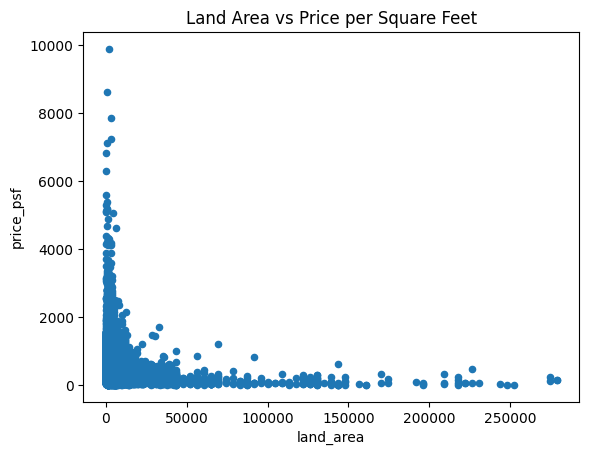

In [7]:
df_transactions[['price_psf', 'land_area']].plot(
    kind='scatter',
    x='land_area',
    y='price_psf',
    title='Land Area vs Price per Square Feet'
)

Based on the plot above, we can see that there is no correlation between `land_area` and `price_psf`.

### Discrete variables (nominal) vs `price_psf`

In [8]:
nominal_vars = ['township', 'building_type', 'tenure']

for var in nominal_vars:
    kruskal_result = kruskal(*df_transactions[[var, target_var]].groupby(var, observed=True)[target_var].apply(list), nan_policy='omit')
    print(f"Kruskal-Wallis result for {var} and {target_var}: {kruskal_result}")

Kruskal-Wallis result for township and price_psf: KruskalResult(statistic=143840.41840357677, pvalue=0.0)
Kruskal-Wallis result for building_type and price_psf: KruskalResult(statistic=71844.01611948658, pvalue=0.0)
Kruskal-Wallis result for tenure and price_psf: KruskalResult(statistic=17776.816993317563, pvalue=0.0)


For Kruskal-Wallis test (DV: continuous, IV: nominal), the null hypothesis H0 is that the population median of all of the groups are equal (thus no association as different groups has the similar population median), while the alternative hypothesis H1 is that the population median of all of the groups are not equal (thus has association as different groups will have different population median).

Since the computed p-values < 0.05 therefore we reject the null hypothesis H0 and conclude that there is association between the nominal variables `township`, `building_type` and `tenure` against `price_psf`.

### Discrete variables (ordinal) vs `price_psf`

In [9]:
ordinal_vars = ['year', 'month', 'day']

for var in ordinal_vars:
    spearman_result = spearmanr(df_transactions[var], df_transactions[target_var], nan_policy='omit')
    print(f"Spearman result for {var} and {target_var}: {spearman_result}")

Spearman result for year and price_psf: SignificanceResult(statistic=0.5955678854090415, pvalue=0.0)
Spearman result for month and price_psf: SignificanceResult(statistic=0.05417040095458992, pvalue=3.471348050926613e-149)
Spearman result for day and price_psf: SignificanceResult(statistic=0.006744450409726356, pvalue=0.0012101790242186501)


For Spearman rank test (DV: continuous, IV: ordinal), the null hypothesis H0 is that there is no correlation between variables, while the alternative hypothesis H1 is that there is a correlation between variables.

Since the computed p-values are close to 0.0 (less than 0.05) therefore we reject the null hypothesis H0 and conclude that there is a correlation between variables. Thus, `year`, `month` and `day` has an impact on the `price_psf`.

### Discrete variables (ratio) vs `price_psf`

In [10]:
ratio_vars = ['n_households', 'population_thousands', 'n_crimes', 'floors', 'rooms']

for var in ratio_vars:
    pearson_result = pearsonr(df_transactions[var], df_transactions[target_var])
    print(f"Pearson correlation test for {var}: {pearson_result}")

Pearson correlation test for n_households: PearsonRResult(statistic=0.4585270925268039, pvalue=0.0)
Pearson correlation test for population_thousands: PearsonRResult(statistic=0.44512550413939594, pvalue=0.0)
Pearson correlation test for n_crimes: PearsonRResult(statistic=-0.46551192428577126, pvalue=0.0)
Pearson correlation test for floors: PearsonRResult(statistic=0.0797170397562012, pvalue=3.51e-321)
Pearson correlation test for rooms: PearsonRResult(statistic=0.05268622045361267, pvalue=3.202016933693272e-141)


However, the Spearman rank test (DV: continuous, IV: ratio) shows otherwise. Similarly, the null hypothesis H0 is that there is no correlation between variables, while the alternative hypothesis H1 is that there is a correlation between variables.

Since the computed p-values are close to 0.0 (less than 0.05) therefore we reject the null hypothesis H0 and conclude that there is a correlation between the ratio variables `n_households`, `population_thousands`, `n_crimes`, `floors`, `rooms` on `price_psf`.

## Encoding for ML-based modelling

Based on the correlation and association tests, the `land_area` have to be dropped as it is uncorrelated with `price_psf`.

But let's encode the features with one hot encoder first before dropping `land_area`.

In [11]:
df_transactions[df_transactions.columns[:12]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 230274 entries, 34996 to 265269
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   township       230274 non-null  category
 1   building_type  230274 non-null  category
 2   tenure         230274 non-null  category
 3   floors         230274 non-null  float64 
 4   rooms          230274 non-null  float64 
 5   land_area      230274 non-null  float64 
 6   built_up       230274 non-null  float64 
 7   price_psf      230274 non-null  float64 
 8   price          230274 non-null  float64 
 9   year           230274 non-null  float64 
 10  month          230274 non-null  float64 
 11  day            230274 non-null  float64 
dtypes: category(3), float64(9)
memory usage: 18.5 MB


In [12]:
encoder_path = ENCODER_MODEL_DIR / 'one_hot_encoder_township_building_type_tenure.joblib'

if os.path.exists(encoder_path):
    ohe = joblib.load(encoder_path)
else:
    raise Exception(f'Encoder not found at {encoder_path}')

df_encoded = ohe.transform(df_transactions[df_transactions.columns[:12]])
df_encoded.info()

d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\category_encoders\utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\category_encoders\utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\category_encoders\utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)


<class 'pandas.core.frame.DataFrame'>
Index: 230274 entries, 34996 to 265269
Columns: 1905 entries, township_BANDAR BARU SRI PETALING to day
dtypes: float64(9), int64(1896)
memory usage: 3.3 GB


In [13]:
df_transactions = pd.concat([df_transactions[df_transactions.columns[12:]], df_encoded], axis=1)
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230274 entries, 34996 to 265269
Columns: 1916 entries, cpi to day
dtypes: datetime64[ns](1), float64(19), int64(1896)
memory usage: 3.3 GB


In [14]:
df_transactions.to_parquet(TRANSFORMED_DATA_DIR / 'transactions_KL_ckpt8_integrated_encoded.parquet')

In [15]:
df_transactions = df_transactions.drop(columns=['land_area'])
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230274 entries, 34996 to 265269
Columns: 1915 entries, cpi to day
dtypes: datetime64[ns](1), float64(18), int64(1896)
memory usage: 3.3 GB


In [16]:
df_transactions.to_parquet(TRANSFORMED_DATA_DIR / 'transactions_KL_ckpt9_integrated_encoded_dropped.parquet')

## Data splitting

In [17]:
df_transactions = df_transactions.sort_values(by=['date'])
df_transactions = df_transactions.drop(columns=['date'])
df_transactions.head()

,cpi,median_income,mean_income,n_households,wellbeing_index,money_supply_millions,unemployment_rate,population_thousands,n_crimes,interest_rate,...,tenure_LEASEHOLD,tenure_FREEHOLD,floors,rooms,built_up,price_psf,price,year,month,day
34996,80.519272,3006.666667,4379.74,299566.666667,100.0,458363.1,3.0,1416.0,8770.0,5.5,...,1,0,1.0,3.000000,1015.0,128.0,129888.0,2000.0,1.0,1.0
34997,80.519272,3006.666667,4379.74,299566.666667,100.0,458363.1,3.0,1416.0,8770.0,5.5,...,1,0,1.0,3.000000,1007.0,122.0,122888.0,2000.0,1.0,1.0
34998,80.519272,3006.666667,4379.74,299566.666667,100.0,458363.1,3.0,1416.0,8770.0,5.5,...,1,0,1.0,3.000000,1015.0,122.0,123888.0,2000.0,1.0,2.0
34999,80.519272,3006.666667,4379.74,299566.666667,100.0,458363.1,3.0,1416.0,8770.0,5.5,...,1,0,2.0,2.000000,672.0,120.0,90000.0,2000.0,1.0,2.0
35000,80.519272,3006.666667,4379.74,299566.666667,100.0,458363.1,3.0,1416.0,8770.0,5.5,...,0,1,1.0,3.078282,1126.0,180.0,338000.0,2000.0,1.0,2.0


In [18]:
df_train = df_transactions.query('year <= 2020')
df_train['year'].value_counts().sort_index()


year
2000.0     6470
2001.0     6494
2002.0     7547
2003.0     8379
2004.0    10449
2005.0     9382
2006.0     8990
2007.0    11603
2008.0    11943
2009.0    13817
2010.0    13409
2011.0    14156
2012.0    12561
2013.0    14271
2014.0    12335
2015.0     9877
2016.0     8573
2017.0     9371
2018.0     8758
2019.0     7388
2020.0     6775
Name: count, dtype: int64

In [19]:
df_test = df_transactions.query('year >= 2021')
df_test['year'].value_counts().sort_index()

year
2021.0    7492
2022.0    8136
2023.0    2098
Name: count, dtype: int64

## Modelling with machine learning methods

From surveyed literature, the popular machine learning approaches for real estate price forecasting are:
1. random forest regression (Ayyasamy et al., 2022)
2. support vector regression (Ayyasamy et al., 2022; D.-Y. Li et al., 2009; Y. Li et al., 2020; Plakandaras et al., 2015)
3. neural networks (Abidoye et al., 2019; Kang et al., 2020; Liu & Wu, 2020; Sa’at et al., 2021; Samadani & Costa, 2021; Xu & Zhang, 2021)

And will be evaluated with the following metrics:
1. MAE
2. MSE
3. RMSE
4. MAPE
5. R-squared

In [20]:
X_train = df_train.drop(columns=['price_psf']).to_numpy()
y_train = df_train['price_psf'].to_numpy()

X_test = df_test.drop(columns=['price_psf']).to_numpy()
y_test = df_test['price_psf'].to_numpy()

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(212548, 1913) (212548,) (17726, 1913) (17726,)


In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_gamma_deviance, mean_poisson_deviance, max_error

def evaluate_model(y_true, y_pred):

    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    me = max_error(y_true, y_pred)
    rmsle = np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2)))
    mpd = mean_poisson_deviance(y_true, y_pred)
    mgd = mean_gamma_deviance(y_true, y_pred)
    

    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}")
    print(f"R2: {r2}")
    print(f"ME: {me}")
    print(f"RMSLE: {rmsle}")
    print(f"MPD: {mpd}")
    print(f"MGD: {mgd}")

    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'r2': r2,
        'me': me,
        'rmsle': rmsle,
        'mpd': mpd,
        'mgd': mgd,
    }

### Random forests

We use default values as there are no reference parameters mentioned in surveyed literature.

Moreover, based on the cross validation experience during imputation, we will perform stratified sampling with proportion so that we could use a smaller dataset which is representative of the population for cross validation:
- The sample size is determined by the learning curve, which is dependent on the estimator
- Sample size for each year will be calculated proportionally based on the number of transactions for each year
- Statistical test will be conducted to check if the mean, median and standard deviation of the sampling distribution is similar to the population distribution

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LearningCurveDisplay
from sklearn.ensemble import RandomForestRegressor

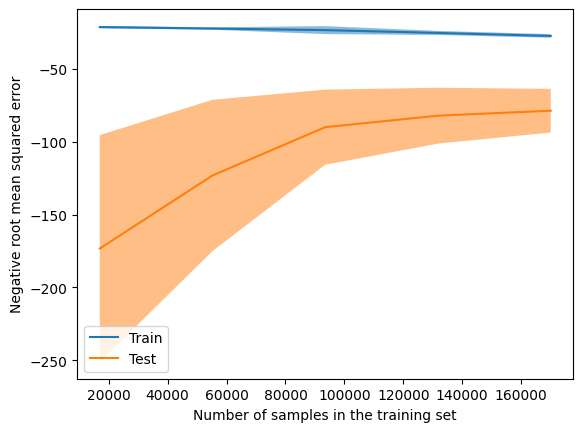

In [25]:
rf_pipeline = Pipeline([('scaler', StandardScaler()), ('model', RandomForestRegressor(random_state=1234, n_jobs=4))])

if os.path.exists(FORECAST_MODEL_DIR / 'rf_learning_curve.joblib'):
    rf_learning_curve = joblib.load(FORECAST_MODEL_DIR / 'rf_learning_curve.joblib')
else:
    rf_learning_curve = LearningCurveDisplay.from_estimator(
        estimator=rf_pipeline,
        X=X_train,
        y=y_train,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=4,
    )
    joblib.dump(rf_learning_curve, FORECAST_MODEL_DIR / 'rf_learning_curve.joblib')

# rf_learning_curve.plot()

Based on the learning curve above, approximately 100k samples have least RMSE on test set, while the RMSE for train set is mostly flat. Thus, we will use 100k samples for cross validation.

In [26]:
def stratify_sample(df: pd.DataFrame, subset: str, sample_size: int):
    sample_size_fraction = sample_size / len(df_train)
    return df.groupby(subset, group_keys=False).apply(lambda x: x.sample(frac=sample_size_fraction, random_state=1234))

In [27]:
sampled_df_train = stratify_sample(df_train, subset='year', sample_size=100_000)
sampled_X_train = sampled_df_train.drop(columns=['price_psf', 'day']).to_numpy()
sampled_y_train = sampled_df_train['price_psf'].to_numpy()
print(sampled_X_train.shape, sampled_y_train.shape)

(100000, 1912) (100000,)


In [28]:
if os.path.exists(FORECAST_MODEL_DIR / 'rf_cv_results.joblib'):
    cv_results_rf = joblib.load(FORECAST_MODEL_DIR / 'rf_cv_results.joblib')
else:
    cv_results_rf = cross_validation_with_pipeline(rf_pipeline, sampled_X_train, sampled_y_train, 'regression')
    joblib.dump(cv_results_rf, FORECAST_MODEL_DIR / 'rf_cv_results.joblib')
    
df_cv_results_rf = pd.DataFrame(cv_results_rf)
df_cv_results_rf

,fit_time,score_time,test_r2,train_r2,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error,test_neg_median_absolute_error,train_neg_median_absolute_error
0,889.269822,1.684441,0.688692,0.986302,-4996.666896,-1004.931852,-70.687106,-31.700660,-0.136663,-0.020332,-1.230,-0.41
1,918.204399,1.853120,0.874508,0.986565,-4419.530128,-989.059223,-66.479547,-31.449312,-0.080807,-0.021043,-1.320,-0.43
2,926.237426,2.273232,0.861012,0.987318,-6940.631146,-918.771956,-83.310450,-30.311251,-0.064717,-0.021745,-1.390,-0.46
3,873.374550,1.957659,0.930017,0.983920,-5182.938178,-1016.901355,-71.992626,-31.888891,-0.048205,-0.023478,-1.560,-0.45
4,264.540587,0.593046,0.880109,0.987973,-10702.891295,-640.637130,-103.454779,-25.310811,-0.039848,-0.023181,-2.415,-0.38


Cross validation on sample data using random forest regression took 19m20s.

In [29]:
if os.path.exists(FORECAST_MODEL_DIR / 'rf_forecasting_pipeline.skops'):
    rf_pipeline = sio.load(FORECAST_MODEL_DIR / 'rf_forecasting_pipeline.skops', trusted=True)
else:
    rf_pipeline.fit(X_train, y_train)
    sio.dump(rf_pipeline, FORECAST_MODEL_DIR / 'rf_forecasting_pipeline.skops')

y_pred = rf_pipeline.predict(X_test)
rf_test_results = evaluate_model(y_test, y_pred)

MSE: 7816.490874555656
RMSE: 88.41092056163455
MAE: 25.041015701982023
MAPE: 0.045024271989159335
R2: 0.9163532319977183
ME: 2810.44
RMSLE: 0.11781819855157823
MPD: 8.338797659452434
MGD: 0.013459595457928198


Random forest regressor took 5m29s to train on train set and predict test set.

### Support vector machines

In [30]:
# from sklearn.svm import SVR

# svr_pipeline = Pipeline([('scaler', StandardScaler()), ('model', SVR())])

# if os.path.exists(FORECAST_MODEL_DIR / 'svr_learning_curve.joblib'):
#     svr_learning_curve = joblib.load(FORECAST_MODEL_DIR / 'svr_learning_curve.joblib')
# else:
#     svr_learning_curve = LearningCurveDisplay.from_estimator(
#         estimator=svr_pipeline,
#         X=X_train,
#         y=y_train,
#         cv=5,
#         scoring='neg_root_mean_squared_error',
#         n_jobs=4,
#     )
#     joblib.dump(svr_learning_curve, FORECAST_MODEL_DIR / 'svr_learning_curve.joblib')

# svr_learning_curve.plot()

In [31]:
# sampled_df_train = stratify_sample(df_train, subset='year', sample_size=100_000)
# sampled_X_train = sampled_df_train.drop(columns=['price_psf', 'day']).to_numpy()
# sampled_y_train = sampled_df_train['price_psf'].to_numpy()
# print(sampled_X_train.shape, sampled_y_train.shape)

In [32]:
# Cross validate the pipeline
# if not os.path.exists(FORECAST_MODEL_DIR / 'cv_results_svr.joblib'):
#     cv_results_svr = cross_validation_with_pipeline(svr_pipeline, sampled_X_train, sampled_y_train, 'regression')
#     joblib.dump(cv_results_svr, FORECAST_MODEL_DIR / 'cv_results_svr.joblib')
# else:
#     cv_results_svr = joblib.load(FORECAST_MODEL_DIR / 'cv_results_svr.joblib')

# df_cv_results_svr = pd.DataFrame(cv_results_svr)
# df_cv_results_svr

SVR did not converge after 535m of cross validation and 175m of learning curve plot. Thus, we will not use SVR.

In [33]:
# if os.path.exists(FORECAST_MODEL_DIR / 'svr_forecasting_pipeline.skops'):
#     svr_pipeline = sio.load(FORECAST_MODEL_DIR / 'svr_forecasting_pipeline.skops', trusted=True)
# else:
#     svr_pipeline.fit(X_train, y_train)
#     sio.dump(svr_pipeline, FORECAST_MODEL_DIR / 'svr_forecasting_pipeline.skops')

# y_pred = svr_pipeline.predict(X_test)
# _ = evaluate_model(y_test, y_pred)

SVR did not converge after 601m of training and predicting.

### Neural networks

Surveyed literature mentioned the following:
1. Three hidden layers with 100 neurons each, RELU activation, RMSProp optimiser and 100 epochs (Mohamed et al., 2023);
2. Two hidden layers with nine and seven neurons respectively, RELU activation, LBFGS optimiser and 5000 epochs (Samadani & Costa, 2021).

We will use the following parameters for grid search:
- Hidden layers: 1, 2, 3
- Neurons: 10, 100
- Activation: RELU
- Optimiser: Adam, LBFGS (Sklearn does not support RMSProp optimiser)
- Epochs: 100, 500

In [34]:
from sklearn.neural_network import MLPRegressor

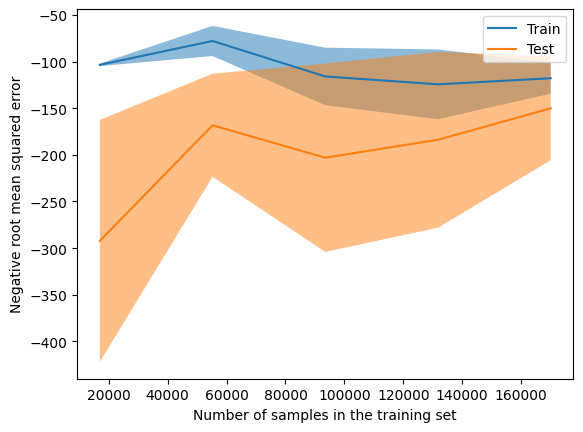

In [36]:
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('model', MLPRegressor(
        hidden_layer_sizes=(100, 100, 100,),
        random_state=1234,
        max_iter=100, 
        early_stopping=True, 
        n_iter_no_change=10, 
        activation='relu', 
        solver='adam',
        learning_rate_init=0.1,
    ))
])

if os.path.exists(FORECAST_MODEL_DIR / 'mlp_3_layers_adam_learning_curve.joblib'):
    mlp_learning_curve = joblib.load(FORECAST_MODEL_DIR / 'mlp_3_layers_adam_learning_curve.joblib')
else:
    mlp_learning_curve = LearningCurveDisplay.from_estimator(
        estimator=mlp_pipeline,
        X=X_train,
        y=y_train,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=4,
    )
    joblib.dump(mlp_learning_curve, FORECAST_MODEL_DIR / 'mlp_3_layers_adam_learning_curve.joblib')

# mlp_learning_curve.plot()

From the learning curve above, the test set RMSE for ANN with three hidden layers and 100 neurons each is lowest at approximately 60k samples, then increases until 100k samples and then decreases again. Thus, we will use 60k samples for cross validation.

The learning curve took 41m23s to complete.

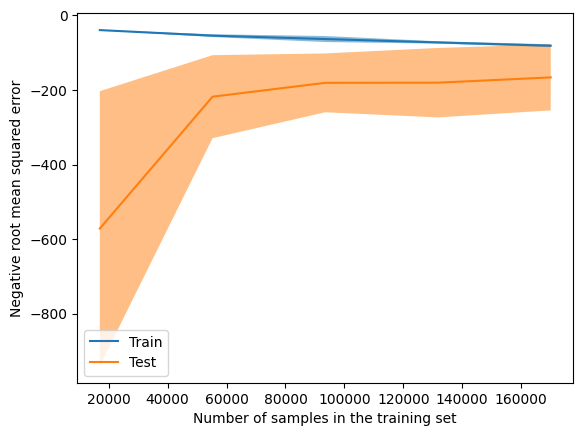

In [37]:
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('model', MLPRegressor(
            hidden_layer_sizes=(10, 10,),
            random_state=1234,
            max_iter=100, 
            early_stopping=True, 
            n_iter_no_change=10, 
            activation='relu', 
            solver='lbfgs',
            learning_rate_init=0.1,
        ))
    ])

if os.path.exists(FORECAST_MODEL_DIR / 'mlp_2_layers_lbfgs_learning_curve.joblib'):
    mlp_learning_curve = joblib.load(FORECAST_MODEL_DIR / 'mlp_2_layers_lbfgs_learning_curve.joblib')
else:
    mlp_learning_curve = LearningCurveDisplay.from_estimator(
        estimator=mlp_pipeline,
        X=X_train,
        y=y_train,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=4,
    )
    joblib.dump(mlp_learning_curve, FORECAST_MODEL_DIR / 'mlp_2_layers_lbfgs_learning_curve.joblib')

# mlp_learning_curve.plot()

From the learning curve above, the test set RMSE for ANN with two hidden layers and 10 neurons each with LBFGS optimiser is lowest at approximately 60k samples, then plateaus. Thus, we will use 60k samples for cross validation.

The learning curve took 29m45s to complete.

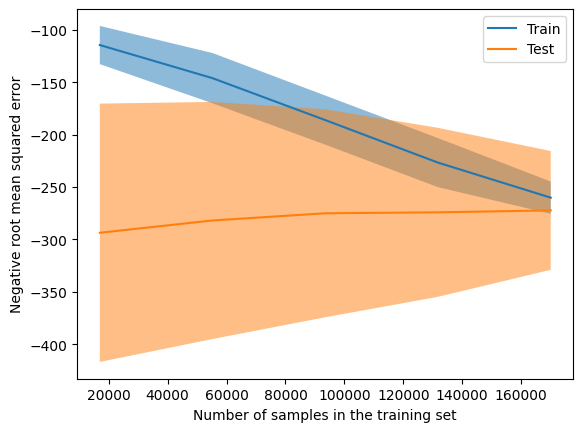

In [38]:
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('model', MLPRegressor(
            hidden_layer_sizes=(10, 10,),
            random_state=1234,
            max_iter=100, 
            early_stopping=True, 
            n_iter_no_change=10, 
            activation='relu', 
            solver='sgd',
            learning_rate='adaptive',
            learning_rate_init=0.1,
        ))
    ])

if os.path.exists(FORECAST_MODEL_DIR / 'mlp_2_layers_sgd_learning_curve.joblib'):
    mlp_learning_curve = joblib.load(FORECAST_MODEL_DIR / 'mlp_2_layers_sgd_learning_curve.joblib')
else:
    mlp_learning_curve = LearningCurveDisplay.from_estimator(
        estimator=mlp_pipeline,
        X=X_train,
        y=y_train,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=4,
    )
    joblib.dump(mlp_learning_curve, FORECAST_MODEL_DIR / 'mlp_2_layers_sgd_learning_curve.joblib')

# mlp_learning_curve.plot()

From the learning curve above, the test set RMSE for ANN with three hidden layers and 10 neurons each with SGD optimiser plateaus from 20k samples onwards, with minimal decrease. Meanwhile, the train set RMSE decreases from 20k samples onwards. Thus we will omit SGD optimiser.

The learning curve took 41m44s to generate.

Based on learning curve produced by ANN with Adam and LBFGS optimiser and omitting ANN with SGD optimiser, we use sample size of 60k for grid search with cross validation.

In [39]:
sampled_df_train = stratify_sample(df_train, subset='year', sample_size=60_000)
sampled_X_train = sampled_df_train.drop(columns=['price_psf', 'day']).to_numpy()
sampled_y_train = sampled_df_train['price_psf'].to_numpy()
print(sampled_X_train.shape, sampled_y_train.shape)

(59998, 1912) (59998,)


### Adam optimiser

In [41]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [
        (100, 100, 100,),
        (10, 10),
    ],
    'learning_rate_init': [0.1, 0.01, 0.001],
    'max_iter': [100, 500],
    'solver': ['adam'],
}

scoring = {
    'mse': 'neg_mean_squared_error',
    'rmse': 'neg_root_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'mape': 'neg_mean_absolute_percentage_error',
    'r2': 'r2',
}

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

if os.path.exists(FORECAST_MODEL_DIR / 'mlp_grid_search_forecasting_adam_large.skops'):
    grid_search = sio.load(FORECAST_MODEL_DIR / 'mlp_grid_search_forecasting_adam_large.skops', trusted=True)
else:
    mlp = MLPRegressor(random_state=1234, activation='relu', early_stopping=True, n_iter_no_change=50)
    grid_search = GridSearchCV(mlp, param_grid, scoring=scoring, refit='rmse', n_jobs=4, cv=5, verbose=3)
    grid_search.fit(X_train_scaled, y_train)
    sio.dump(grid_search, FORECAST_MODEL_DIR / 'mlp_grid_search_forecasting_adam_large.skops')

The grid search took 488m44s to go through all parameter combinations for all folds.

In [42]:
columns = [
    'mean_test_mse', 
    'mean_test_rmse', 
    'mean_test_mae', 
    'mean_test_mape', 
    'mean_test_r2', 
    'param_hidden_layer_sizes', 
    'param_learning_rate_init', 
    'param_max_iter', 
    'param_early_stopping', 
    'param_n_iter_no_change',
]

df_grid_search_adam_large = pd.DataFrame(data={col: grid_search.cv_results_.get(col) for col in columns})
df_grid_search_adam_large.sort_values(by=['mean_test_rmse', 'mean_test_mae', 'mean_test_mape', 'mean_test_r2'], ascending=False)

,mean_test_mse,mean_test_rmse,mean_test_mae,mean_test_mape,mean_test_r2,param_hidden_layer_sizes,param_learning_rate_init,param_max_iter,param_early_stopping,param_n_iter_no_change
3,-18587.936498,-126.606099,-66.267204,-0.232282,0.661632,"(100, 100, 100)",0.01,500,None,None
4,-19618.374164,-133.373364,-75.942263,-0.276750,0.600647,"(100, 100, 100)",0.001,100,None,None
5,-19618.374164,-133.373364,-75.942263,-0.276750,0.600647,"(100, 100, 100)",0.001,500,None,None
8,-19864.915588,-133.994076,-72.057013,-0.264373,0.615100,"(10, 10)",0.01,100,None,None
9,-19864.915588,-133.994076,-72.057013,-0.264373,0.615100,"(10, 10)",0.01,500,None,None
10,-20218.171116,-134.767494,-72.158570,-0.263154,0.604617,"(10, 10)",0.001,100,None,None
11,-20218.171116,-134.767494,-72.158570,-0.263154,0.604617,"(10, 10)",0.001,500,None,None
6,-24729.323618,-145.467140,-75.959497,-0.287878,0.522556,"(10, 10)",0.1,100,None,None
7,-24729.323618,-145.467140,-75.959497,-0.287878,0.522556,"(10, 10)",0.1,500,None,None
2,-24565.802536,-151.256931,-68.641251,-0.249708,0.461767,"(100, 100, 100)",0.01,100,None,None


In [43]:
param_grid = {
    'hidden_layer_sizes': [
        (10, 10, 10,),
        (10, 10),
        (10,)
    ],
    'learning_rate_init': [0.1, 0.01, 0.001],
    'max_iter': [100, 500],
    'solver': ['adam'],
}

scoring = {
    'mse': 'neg_mean_squared_error',
    'rmse': 'neg_root_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'mape': 'neg_mean_absolute_percentage_error',
    'r2': 'r2',
}

if os.path.exists(FORECAST_MODEL_DIR / 'mlp_grid_search_forecasting_adam_small.skops'):
    grid_search = sio.load(FORECAST_MODEL_DIR / 'mlp_grid_search_forecasting_adam_small.skops', trusted=True)
else:
    mlp = MLPRegressor(random_state=1234, activation='relu', early_stopping=True, n_iter_no_change=50)
    grid_search = GridSearchCV(mlp, param_grid, scoring=scoring, refit='rmse', n_jobs=4, cv=5, verbose=3)
    grid_search.fit(X_train_scaled, y_train)
    sio.dump(grid_search, FORECAST_MODEL_DIR / 'mlp_grid_search_forecasting_adam_small.skops')

The grid search took 209m52s to go through all parameter combinations for train and predict.

In [44]:
df_grid_search_adam_small = pd.DataFrame(data={col: grid_search.cv_results_.get(col) for col in columns})
df_grid_search_adam_small.sort_values(by=['mean_test_rmse', 'mean_test_mae', 'mean_test_mape', 'mean_test_r2'], ascending=False)

,mean_test_mse,mean_test_rmse,mean_test_mae,mean_test_mape,mean_test_r2,param_hidden_layer_sizes,param_learning_rate_init,param_max_iter,param_early_stopping,param_n_iter_no_change
8,-19864.915588,-133.994076,-72.057013,-0.264373,0.615100,"(10, 10)",0.01,100,None,None
9,-19864.915588,-133.994076,-72.057013,-0.264373,0.615100,"(10, 10)",0.01,500,None,None
10,-20218.171116,-134.767494,-72.158570,-0.263154,0.604617,"(10, 10)",0.001,100,None,None
11,-20218.171116,-134.767494,-72.158570,-0.263154,0.604617,"(10, 10)",0.001,500,None,None
0,-22066.384125,-136.023481,-76.147902,-0.294263,0.592522,"(10, 10, 10)",0.1,100,None,None
1,-22066.384125,-136.023481,-76.147902,-0.294263,0.592522,"(10, 10, 10)",0.1,500,None,None
2,-22190.889031,-139.084266,-74.156856,-0.269567,0.582141,"(10, 10, 10)",0.01,100,None,None
3,-22190.889031,-139.084266,-74.156856,-0.269567,0.582141,"(10, 10, 10)",0.01,500,None,None
6,-24729.323618,-145.467140,-75.959497,-0.287878,0.522556,"(10, 10)",0.1,100,None,None
7,-24729.323618,-145.467140,-75.959497,-0.287878,0.522556,"(10, 10)",0.1,500,None,None


### LBFGS optimiser

In [45]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [
        (100, 100, 100,),
        (10, 10),
    ],
    'learning_rate_init': [0.1, 0.01, 0.001],
    'max_iter': [100, 500],
    'solver': ['lbfgs'],
}

scoring = {
    'mse': 'neg_mean_squared_error',
    'rmse': 'neg_root_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'mape': 'neg_mean_absolute_percentage_error',
    'r2': 'r2',
}

if os.path.exists(FORECAST_MODEL_DIR / 'mlp_grid_search_forecasting_lbfgs_large.skops'):
    grid_search = sio.load(FORECAST_MODEL_DIR / 'mlp_grid_search_forecasting_lbfgs_large.skops', trusted=True)
else:
    mlp = MLPRegressor(random_state=1234, activation='relu', early_stopping=True, n_iter_no_change=50)
    grid_search = GridSearchCV(mlp, param_grid, scoring=scoring, refit='rmse', n_jobs=4, cv=5, verbose=3)
    grid_search.fit(X_train_scaled, y_train)
    sio.dump(grid_search, FORECAST_MODEL_DIR / 'mlp_grid_search_forecasting_lbfgs_large.skops')

The grid search took 723m29s to go through all parameter combinations for train and predict.

In [46]:
df_grid_search_lbfgs_large = pd.DataFrame(data={col: grid_search.cv_results_.get(col) for col in columns})
df_grid_search_lbfgs_large.sort_values(by=['mean_test_rmse', 'mean_test_mae', 'mean_test_mape', 'mean_test_r2'], ascending=False)

,mean_test_mse,mean_test_rmse,mean_test_mae,mean_test_mape,mean_test_r2,param_hidden_layer_sizes,param_learning_rate_init,param_max_iter,param_early_stopping,param_n_iter_no_change
0,-28074.161000,-145.931231,-54.054741,-0.197948,0.466383,"(100, 100, 100)",0.1,100,None,None
2,-28074.161000,-145.931231,-54.054741,-0.197948,0.466383,"(100, 100, 100)",0.01,100,None,None
4,-28074.161000,-145.931231,-54.054741,-0.197948,0.466383,"(100, 100, 100)",0.001,100,None,None
1,-27054.635226,-147.148715,-39.161723,-0.142882,0.467409,"(100, 100, 100)",0.1,500,None,None
3,-27054.635226,-147.148715,-39.161723,-0.142882,0.467409,"(100, 100, 100)",0.01,500,None,None
5,-27054.635226,-147.148715,-39.161723,-0.142882,0.467409,"(100, 100, 100)",0.001,500,None,None
6,-36468.390694,-171.647146,-69.688174,-0.249671,0.313402,"(10, 10)",0.1,100,None,None
8,-36468.390694,-171.647146,-69.688174,-0.249671,0.313402,"(10, 10)",0.01,100,None,None
10,-36468.390694,-171.647146,-69.688174,-0.249671,0.313402,"(10, 10)",0.001,100,None,None
7,-66150.706421,-220.431412,-71.798104,-0.242812,-0.195045,"(10, 10)",0.1,500,None,None


In [47]:
param_grid = {
    'hidden_layer_sizes': [
        (10, 10, 10,),
        (10, 10),
        (10,)
    ],
    'learning_rate_init': [0.1, 0.01, 0.001],
    'max_iter': [100, 500],
    'solver': ['lbfgs'],
}

scoring = {
    'mse': 'neg_mean_squared_error',
    'rmse': 'neg_root_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'mape': 'neg_mean_absolute_percentage_error',
    'r2': 'r2',
}

if os.path.exists(FORECAST_MODEL_DIR / 'mlp_grid_search_forecasting_lbfgs_small.skops'):
    grid_search = sio.load(FORECAST_MODEL_DIR / 'mlp_grid_search_forecasting_lbfgs_small.skops', trusted=True)
else:
    mlp = MLPRegressor(random_state=1234, activation='relu', early_stopping=True, n_iter_no_change=50)
    grid_search = GridSearchCV(mlp, param_grid, scoring=scoring, refit='rmse', n_jobs=4, cv=5, verbose=3)
    grid_search.fit(X_train_scaled, y_train)
    sio.dump(grid_search, FORECAST_MODEL_DIR / 'mlp_grid_search_forecasting_lbfgs_small.skops')

The grid search took 498m47s to go through all parameter combinations for train and predict.

In [48]:
df_grid_search_lbfgs_small = pd.DataFrame(data={col: grid_search.cv_results_.get(col) for col in columns})
df_grid_search_lbfgs_small.sort_values(by=['mean_test_rmse', 'mean_test_mae', 'mean_test_mape', 'mean_test_r2'], ascending=False)

,mean_test_mse,mean_test_rmse,mean_test_mae,mean_test_mape,mean_test_r2,param_hidden_layer_sizes,param_learning_rate_init,param_max_iter,param_early_stopping,param_n_iter_no_change
12,-28924.599141,-153.409357,-64.188412,-0.236369,0.437332,"(10,)",0.1,100,None,None
14,-28924.599141,-153.409357,-64.188412,-0.236369,0.437332,"(10,)",0.01,100,None,None
16,-28924.599141,-153.409357,-64.188412,-0.236369,0.437332,"(10,)",0.001,100,None,None
6,-36468.390694,-171.647146,-69.688174,-0.249671,0.313402,"(10, 10)",0.1,100,None,None
8,-36468.390694,-171.647146,-69.688174,-0.249671,0.313402,"(10, 10)",0.01,100,None,None
10,-36468.390694,-171.647146,-69.688174,-0.249671,0.313402,"(10, 10)",0.001,100,None,None
0,-43901.057274,-181.729107,-67.770563,-0.242402,0.156950,"(10, 10, 10)",0.1,100,None,None
2,-43901.057274,-181.729107,-67.770563,-0.242402,0.156950,"(10, 10, 10)",0.01,100,None,None
4,-43901.057274,-181.729107,-67.770563,-0.242402,0.156950,"(10, 10, 10)",0.001,100,None,None
13,-45489.188871,-188.119614,-67.897534,-0.239867,0.156791,"(10,)",0.1,500,None,None


From the results, we observe that:
1. Small models with LBFGS optimiser performed worse that large models.
2. Small models with ADAM optimiser performed worse than large models.
3. Models with ADAM optimiser performed better than models with LBFGS optimiser.
4. Models with LBFGS optimiser took longer to train and predict than models with ADAM optimiser.
5. The best model is ANN with three hidden layers and 100 neurons each with ADAM optimiser, 0.01 initial learning rate and 500 max iterations.

## Evaluate models on test set

We evaluate the following models on the test set:
1. Random forest regressor with default parameters
2. ANN with three hidden layers and 100 neurons each with ADAM optimiser, 0.01 initial learning rate and 500 max iterations
3. ANN with two hidden layers and 10 neurons each with ADAM optimiser, 0.01 initial learning rate and 100 max iterations
4. ANN with three hidden layers and 100 neurons each with ADAM optimiser, 0.001 initial learning rate and 100 max iterations
5. ANN with two hidden layers and 10 neurons each with ADAM optimiser, 0.001 initial learning rate and 100 max iterations
6. ANN with three hidden layers and 10 neurons each with ADAM optimiser, 0.01 initial learning rate and 100 max iterations
7. ANN with three hidden layers and 10 neurons each with ADAM optimiser, 0.1 initial learning rate and 100 max iterations
8. ANN with three hidden layers and 10 neurons each with ADAM optimiser, 0.001 initial learning rate and 500 max iterations
9. ANN with default parameters

In [94]:
if os.path.exists(FORECAST_MODEL_DIR / 'mlp_100_100_100_lr01_forecasting.skops'):
    mlp = sio.load(FORECAST_MODEL_DIR / 'mlp_100_100_100_lr01_forecasting.skops', trusted=True)
else:
    mlp = MLPRegressor(
        random_state=1234,
        max_iter=500, 
        early_stopping=True, 
        n_iter_no_change=50, 
        activation='relu', 
        solver='adam',
        learning_rate_init=0.01,
        hidden_layer_sizes=(100, 100, 100),
    )
    mlp.fit(X_train_scaled, y_train)
    sio.dump(mlp, FORECAST_MODEL_DIR / 'mlp_100_100_100_lr01_forecasting.skops')

y_pred = mlp.predict(X_test_scaled)
mlp_100_100_100_lr01_results = evaluate_model(y_test, y_pred)

MSE: 13154.073511685863
RMSE: 114.6912093915042
MAE: 62.85791344755517
MAPE: 0.14532779054882733
R2: 0.8592340536213453
ME: 3436.605234431905
RMSLE: 0.20971160561996785
MPD: 17.67752159617999
MGD: 0.04200514700951074


This neural network with 3 layers and 100 neurons each took 75m33s to train and predict.

In [130]:
if os.path.exists(FORECAST_MODEL_DIR / 'mlp_10_10_lr01_forecasting.skops'):
    mlp = sio.load(FORECAST_MODEL_DIR / 'mlp_10_10_lr01_forecasting.skops', trusted=True)
else:
    mlp = MLPRegressor(
        random_state=1234,
        max_iter=100, 
        early_stopping=True, 
        n_iter_no_change=50, 
        activation='relu', 
        solver='adam',
        learning_rate_init=0.01,
        hidden_layer_sizes=(10, 10),
    )
    mlp.fit(X_train_scaled, y_train)
    sio.dump(mlp, FORECAST_MODEL_DIR / 'mlp_10_10_lr01_forecasting.skops')

y_pred = mlp.predict(X_test_scaled)
mlp_10_10_lr01_results = evaluate_model(y_test, y_pred)

MSE: 36233.52717887866
RMSE: 190.35106298331687
MAE: 132.69502631163508
MAPE: 0.3234528920953317
R2: 0.6122534407732777
ME: 3943.966906398413
RMSLE: 0.3461309379193723
MPD: 52.38400585279181
MGD: 0.10406077562445783


This neural network with 2 layers and 10 neurons each took 29m32s to train and predict.

In [111]:
if os.path.exists(FORECAST_MODEL_DIR / 'mlp_100_100_100_lr001_forecasting.skops'):
    mlp = sio.load(FORECAST_MODEL_DIR / 'mlp_100_100_100_lr001_forecasting.skops', trusted=True)
else:
    mlp = MLPRegressor(
        random_state=1234,
        max_iter=100, 
        early_stopping=True, 
        n_iter_no_change=50, 
        activation='relu', 
        solver='adam',
        learning_rate_init=0.001,
        hidden_layer_sizes=(100, 100, 100),
    )
    mlp.fit(X_train_scaled, y_train)
    sio.dump(mlp, FORECAST_MODEL_DIR / 'mlp_100_100_100_lr001_forecasting.skops')

y_pred = mlp.predict(X_test_scaled)
mlp_100_100_100_lr001_results = evaluate_model(y_test, y_pred)

MSE: 38294.53441318915
RMSE: 195.68989348760235
MAE: 139.72211862403324
MAPE: 0.34650310690732
R2: 0.590197943396497
ME: 3919.348381994718
RMSLE: 0.35886358938132573
MPD: 55.72147613934251
MGD: 0.10929036391148506


This neural network with 3 layers and 100 neurons each took 15m22s to train and predict.

In [116]:
if os.path.exists(FORECAST_MODEL_DIR / 'mlp_10_10_lr001_forecasting.skops'):
    mlp = sio.load(FORECAST_MODEL_DIR / 'mlp_10_10_lr001_forecasting.skops', trusted=True)
else:
    mlp = MLPRegressor(
        random_state=1234,
        max_iter=100, 
        early_stopping=True, 
        n_iter_no_change=50, 
        activation='relu', 
        solver='adam',
        learning_rate_init=0.01,
        hidden_layer_sizes=(10, 10),
    )
    mlp.fit(X_train_scaled, y_train)
    sio.dump(mlp, FORECAST_MODEL_DIR / 'mlp_10_10_lr001_forecasting.skops')

y_pred = mlp.predict(X_test_scaled)
mlp_10_10_lr001_results = evaluate_model(y_test, y_pred)

MSE: 36233.52717887866
RMSE: 190.35106298331687
MAE: 132.69502631163508
MAPE: 0.3234528920953317
R2: 0.6122534407732777
ME: 3943.966906398413
RMSLE: 0.3461309379193723
MPD: 52.38400585279181
MGD: 0.10406077562445783


This neural network with 2 layers and 10 neurons each took 3m37s to train and predict.

In [118]:
if os.path.exists(FORECAST_MODEL_DIR / 'mlp_10_10_10_lr01_forecasting.skops'):
    mlp = sio.load(FORECAST_MODEL_DIR / 'mlp_10_10_10_lr01_forecasting.skops', trusted=True)
else:
    mlp = MLPRegressor(
        random_state=1234,
        max_iter=100, 
        early_stopping=True, 
        n_iter_no_change=50, 
        activation='relu', 
        solver='adam',
        learning_rate_init=0.001,
        hidden_layer_sizes=(10, 10, 10),
    )
    mlp.fit(X_train_scaled, y_train)
    sio.dump(mlp, FORECAST_MODEL_DIR / 'mlp_10_10_10_lr01_forecasting.skops')

y_pred = mlp.predict(X_test_scaled)
mlp_10_10_10_lr01_results = evaluate_model(y_test, y_pred)

MSE: 37070.27808585988
RMSE: 192.53643313892536
MAE: 133.67360961651966
MAPE: 0.3225716728268969
R2: 0.6032991017846923
ME: 3940.3880784022267
RMSLE: 0.36768896039594756
MPD: 58.66345390669281
MGD: 0.1435729874800499


This neural network with 3 layers and 10 neurons each took 4m4s to train and predict.

In [120]:
if os.path.exists(FORECAST_MODEL_DIR / 'mlp_10_10_10_lr001_forecasting.skops'):
    mlp = sio.load(FORECAST_MODEL_DIR / 'mlp_10_10_10_lr001_forecasting.skops', trusted=True)
else:
    mlp = MLPRegressor(
        random_state=1234,
        max_iter=100, 
        early_stopping=True, 
        n_iter_no_change=50, 
        activation='relu', 
        solver='adam',
        learning_rate_init=0.001,
        hidden_layer_sizes=(10, 10, 10),
    )
    mlp.fit(X_train_scaled, y_train)
    sio.dump(mlp, FORECAST_MODEL_DIR / 'mlp_10_10_10_lr001_forecasting.skops')

y_pred = mlp.predict(X_test_scaled)
mlp_10_10_10_lr001_results = evaluate_model(y_test, y_pred)

MSE: 37070.27808585988
RMSE: 192.53643313892536
MAE: 133.67360961651966
MAPE: 0.3225716728268969
R2: 0.6032991017846923
ME: 3940.3880784022267
RMSLE: 0.36768896039594756
MPD: 58.66345390669281
MGD: 0.1435729874800499


This neural network with 3 layers and 10 neurons each took 4m12s to train and predict.

In [110]:
if os.path.exists(FORECAST_MODEL_DIR / 'mlp_10_10_10_lr1_forecasting.skops'):
    mlp = sio.load(FORECAST_MODEL_DIR / 'mlp_10_10_10_lr1_forecasting.skops', trusted=True)
else:
    mlp = MLPRegressor(
        random_state=1234,
        max_iter=100, 
        early_stopping=True, 
        n_iter_no_change=50, 
        activation='relu', 
        solver='adam',
        learning_rate_init=0.001,
        hidden_layer_sizes=(10, 10, 10),
    )
    mlp.fit(X_train_scaled, y_train)
    sio.dump(mlp, FORECAST_MODEL_DIR / 'mlp_10_10_10_lr001_forecasting.skops')

y_pred = mlp.predict(X_test_scaled)
mlp_10_10_10_lr1_results = evaluate_model(y_test, y_pred)

MSE: 37070.27808585988
RMSE: 192.53643313892536
MAE: 133.67360961651966
MAPE: 0.3225716728268969
R2: 0.6032991017846923
ME: 3940.3880784022267
RMSLE: 0.36768896039594756
MPD: 58.66345390669281
MGD: 0.1435729874800499


This neural network with 3 layers and 10 neurons each took 4m6s to train and predict.

In [114]:
if os.path.exists(FORECAST_MODEL_DIR / 'mlp_default_forecasting.skops'):
    mlp = sio.load(FORECAST_MODEL_DIR / 'mlp_default_forecasting.skops', trusted=True)
else:
    mlp = MLPRegressor(
        random_state=1234,
        early_stopping=True,        
    )
    mlp.fit(X_train_scaled, y_train)
    sio.dump(mlp, FORECAST_MODEL_DIR / 'mlp_default_forecasting.skops')

y_pred = mlp.predict(X_test_scaled)
mlp_default_results = evaluate_model(y_test, y_pred)

MSE: 36411.769981364654
RMSE: 190.8186835227742
MAE: 133.78406988066806
MAPE: 0.33264830891849245
R2: 0.6103460075545996
ME: 3955.755693254393
RMSLE: 0.3520016296469234
MPD: 53.28714449039693
MGD: 0.1063310519751876


This neural network with 2 layers and 10 neurons each took 29m32s to train and predict.

## Statistical evaluation of machine learning models on test set

Similar to time series models, We will employ three statistical tests to evaluate the performance of the models:
1. Friedman test
2. Iman-Davenport test
3. Nemenyi post-hoc test

These can be performed via the following steps as outlined in Zhan et al. (2023):
1. Ranking the performance of each algorithm according to different evaluation measures to obtain an average ranking for each algorithm;
2. Using Friedman and Iman–Davenport to test whether the algorithms all perform equally; 
3. Utilizing the Nemenyi post-hoc test to further distinguish between the algorithms.

In [131]:
test_results = {
    'random_forest': rf_test_results,
    'mlp_100_100_100_lr01': mlp_100_100_100_lr01_results,
    'mlp_10_10_lr01': mlp_10_10_lr01_results,
    'mlp_100_100_100_lr001': mlp_100_100_100_lr001_results,
    'mlp_10_10_lr001': mlp_10_10_lr001_results,
    'mlp_10_10_10_lr01': mlp_10_10_10_lr01_results,
    'mlp_10_10_10_lr001': mlp_10_10_10_lr001_results,
    'mlp_10_10_10_lr1': mlp_10_10_10_lr1_results,
    'mlp_default': mlp_default_results,
}

df_ml_test_results = pd.DataFrame(test_results).T.reset_index().rename(columns={'index': 'model'})
df_ml_test_results

,model,mse,rmse,mae,mape,r2,me,rmsle,mpd,mgd
0,random_forest,7816.490875,88.410921,25.041016,0.045024,0.916353,2810.440000,0.117818,8.338798,0.013460
1,mlp_100_100_100_lr01,13154.073512,114.691209,62.857913,0.145328,0.859234,3436.605234,0.209712,17.677522,0.042005
2,mlp_10_10_lr01,36233.527179,190.351063,132.695026,0.323453,0.612253,3943.966906,0.346131,52.384006,0.104061
3,mlp_100_100_100_lr001,38294.534413,195.689893,139.722119,0.346503,0.590198,3919.348382,0.358864,55.721476,0.109290
4,mlp_10_10_lr001,36233.527179,190.351063,132.695026,0.323453,0.612253,3943.966906,0.346131,52.384006,0.104061
5,mlp_10_10_10_lr01,37070.278086,192.536433,133.673610,0.322572,0.603299,3940.388078,0.367689,58.663454,0.143573
6,mlp_10_10_10_lr001,37070.278086,192.536433,133.673610,0.322572,0.603299,3940.388078,0.367689,58.663454,0.143573
7,mlp_10_10_10_lr1,37070.278086,192.536433,133.673610,0.322572,0.603299,3940.388078,0.367689,58.663454,0.143573
8,mlp_default,36411.769981,190.818684,133.784070,0.332648,0.610346,3955.755693,0.352002,53.287144,0.106331


Based on the results above, the best model is random forest with default parameters, which outperformed the neural networks.

### Assign rank to each model based on each evaluation metric

In [132]:
metrics = ['mse', 'rmse', 'mae', 'mape', 'r2', 'me', 'rmsle', 'mpd', 'mgd']

for metric in metrics:
    df_ml_test_results['rank_' + metric] = df_ml_test_results[metric].rank()

df_ml_test_results

,model,mse,rmse,mae,mape,r2,me,rmsle,mpd,mgd,rank_mse,rank_rmse,rank_mae,rank_mape,rank_r2,rank_me,rank_rmsle,rank_mpd,rank_mgd
0,random_forest,7816.490875,88.410921,25.041016,0.045024,0.916353,2810.440000,0.117818,8.338798,0.013460,1.0,1.0,1.0,1.0,9.0,1.0,1.0,1.0,1.0
1,mlp_100_100_100_lr01,13154.073512,114.691209,62.857913,0.145328,0.859234,3436.605234,0.209712,17.677522,0.042005,2.0,2.0,2.0,2.0,8.0,2.0,2.0,2.0,2.0
2,mlp_10_10_lr01,36233.527179,190.351063,132.695026,0.323453,0.612253,3943.966906,0.346131,52.384006,0.104061,3.5,3.5,3.5,6.5,6.5,7.5,3.5,3.5,3.5
3,mlp_100_100_100_lr001,38294.534413,195.689893,139.722119,0.346503,0.590198,3919.348382,0.358864,55.721476,0.109290,9.0,9.0,9.0,9.0,1.0,3.0,6.0,6.0,6.0
4,mlp_10_10_lr001,36233.527179,190.351063,132.695026,0.323453,0.612253,3943.966906,0.346131,52.384006,0.104061,3.5,3.5,3.5,6.5,6.5,7.5,3.5,3.5,3.5
5,mlp_10_10_10_lr01,37070.278086,192.536433,133.673610,0.322572,0.603299,3940.388078,0.367689,58.663454,0.143573,7.0,7.0,6.0,4.0,3.0,5.0,8.0,8.0,8.0
6,mlp_10_10_10_lr001,37070.278086,192.536433,133.673610,0.322572,0.603299,3940.388078,0.367689,58.663454,0.143573,7.0,7.0,6.0,4.0,3.0,5.0,8.0,8.0,8.0
7,mlp_10_10_10_lr1,37070.278086,192.536433,133.673610,0.322572,0.603299,3940.388078,0.367689,58.663454,0.143573,7.0,7.0,6.0,4.0,3.0,5.0,8.0,8.0,8.0
8,mlp_default,36411.769981,190.818684,133.784070,0.332648,0.610346,3955.755693,0.352002,53.287144,0.106331,5.0,5.0,8.0,8.0,5.0,9.0,5.0,5.0,5.0


In [133]:
df_ml_test_results['mean_rank'] = df_ml_test_results[[col for col in df_ml_test_results.columns if 'rank' in col]].mean(axis=1)
df_ml_test_results

,model,mse,rmse,mae,mape,r2,me,rmsle,mpd,mgd,rank_mse,rank_rmse,rank_mae,rank_mape,rank_r2,rank_me,rank_rmsle,rank_mpd,rank_mgd,mean_rank
0,random_forest,7816.490875,88.410921,25.041016,0.045024,0.916353,2810.440000,0.117818,8.338798,0.013460,1.0,1.0,1.0,1.0,9.0,1.0,1.0,1.0,1.0,1.888889
1,mlp_100_100_100_lr01,13154.073512,114.691209,62.857913,0.145328,0.859234,3436.605234,0.209712,17.677522,0.042005,2.0,2.0,2.0,2.0,8.0,2.0,2.0,2.0,2.0,2.666667
2,mlp_10_10_lr01,36233.527179,190.351063,132.695026,0.323453,0.612253,3943.966906,0.346131,52.384006,0.104061,3.5,3.5,3.5,6.5,6.5,7.5,3.5,3.5,3.5,4.611111
3,mlp_100_100_100_lr001,38294.534413,195.689893,139.722119,0.346503,0.590198,3919.348382,0.358864,55.721476,0.109290,9.0,9.0,9.0,9.0,1.0,3.0,6.0,6.0,6.0,6.444444
4,mlp_10_10_lr001,36233.527179,190.351063,132.695026,0.323453,0.612253,3943.966906,0.346131,52.384006,0.104061,3.5,3.5,3.5,6.5,6.5,7.5,3.5,3.5,3.5,4.611111
5,mlp_10_10_10_lr01,37070.278086,192.536433,133.673610,0.322572,0.603299,3940.388078,0.367689,58.663454,0.143573,7.0,7.0,6.0,4.0,3.0,5.0,8.0,8.0,8.0,6.222222
6,mlp_10_10_10_lr001,37070.278086,192.536433,133.673610,0.322572,0.603299,3940.388078,0.367689,58.663454,0.143573,7.0,7.0,6.0,4.0,3.0,5.0,8.0,8.0,8.0,6.222222
7,mlp_10_10_10_lr1,37070.278086,192.536433,133.673610,0.322572,0.603299,3940.388078,0.367689,58.663454,0.143573,7.0,7.0,6.0,4.0,3.0,5.0,8.0,8.0,8.0,6.222222
8,mlp_default,36411.769981,190.818684,133.784070,0.332648,0.610346,3955.755693,0.352002,53.287144,0.106331,5.0,5.0,8.0,8.0,5.0,9.0,5.0,5.0,5.0,6.111111


### Friedman test

H0: All models perform equally well.

H1: At least one model performs differently.

In [134]:
number_of_models = len(df_ml_test_results)
number_of_metrics = len(metrics)

t_chi_square = 12 * number_of_metrics / (number_of_metrics * (number_of_metrics + 1)) * \
    sum((df_ml_test_results['mean_rank'] - ((number_of_models * + 1) / 2)) ** 2)
print(f'Degrees of freedom (k-1): {number_of_models - 1}')
print(f't_chi_square: {t_chi_square}')

Degrees of freedom (k-1): 8
t_chi_square: 30.574074074074073


In [135]:
from scipy.stats import friedmanchisquare

friedmanchisquare(*df_ml_test_results[metrics].values)

FriedmanchisquareResult(statistic=29.085990338164265, pvalue=0.00030626587878497275)

With DOF = 8 at alpha = 0.05, the critical value is 15.51 (see [link](ttps://people.smp.uq.edu.au/YoniNazarathy/stat_models_B_course_spring_07/distributions/chisqtab.pdf)).

Since the computed statistic (30.57) > critical value (15.51), we reject the null hypothesis H0 and conclude that there is statistically significant difference in the performance of all algorithms.

### Iman-Davenport test

H0: All models perform equally well.

H1: At least one model performs differently.

In [136]:
t_chi_square = 46.26
d = number_of_metrics
k = number_of_models

(d - 1) * t_chi_square / (d * (k - 1) - t_chi_square)

14.377622377622377

In [137]:
t_F = (number_of_metrics - 1) * t_chi_square / (number_of_metrics * (number_of_models - 1) - t_chi_square)
print(f'Degrees of freedom 1 (d-1): {number_of_metrics - 1}')
print(f'Degrees of freedom 2 (d-1)(k-1): {(number_of_metrics - 1) * (number_of_models - 1)}')
print(f't_F: {t_F}')

Degrees of freedom 1 (d-1): 8
Degrees of freedom 2 (d-1)(k-1): 64
t_F: 14.377622377622377


With DOF1 = 8 and DOF2 = 64 at alpha = 0.05, the critical value is 2.0878 which is interpolated, similar to time series dataset (see [link](https://www.stat.purdue.edu/~lfindsen/stat503/F_alpha_05.pdf)).

Since the computed statistic (14.38) > critical value (2.0878), we reject the null hypothesis H0 and conclude that there is statistically significant difference in the performance of all algorithms.

Note that the Iman-Davenport test is only useful when there are more evaluation metrics (> 5), as 𝑇𝜒2 will gradually be biased towards chi-square random variables with degrees of freedom 𝑘 − 1.

### Nemenyi post-hoc test

We can conduct the Nemenyi post-hoc test to find exactly which groups have different means.

In [138]:
df_ml_metrics = df_ml_test_results[metrics].T.rename(columns=df_ml_test_results['model']).reset_index(drop=True)
df_ml_metrics

,random_forest,mlp_100_100_100_lr01,mlp_10_10_lr01,mlp_100_100_100_lr001,mlp_10_10_lr001,mlp_10_10_10_lr01,mlp_10_10_10_lr001,mlp_10_10_10_lr1,mlp_default
0,7816.490875,13154.073512,36233.527179,38294.534413,36233.527179,37070.278086,37070.278086,37070.278086,36411.769981
1,88.410921,114.691209,190.351063,195.689893,190.351063,192.536433,192.536433,192.536433,190.818684
2,25.041016,62.857913,132.695026,139.722119,132.695026,133.673610,133.673610,133.673610,133.784070
3,0.045024,0.145328,0.323453,0.346503,0.323453,0.322572,0.322572,0.322572,0.332648
4,0.916353,0.859234,0.612253,0.590198,0.612253,0.603299,0.603299,0.603299,0.610346
5,2810.440000,3436.605234,3943.966906,3919.348382,3943.966906,3940.388078,3940.388078,3940.388078,3955.755693
6,0.117818,0.209712,0.346131,0.358864,0.346131,0.367689,0.367689,0.367689,0.352002
7,8.338798,17.677522,52.384006,55.721476,52.384006,58.663454,58.663454,58.663454,53.287144
8,0.013460,0.042005,0.104061,0.109290,0.104061,0.143573,0.143573,0.143573,0.106331


d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\autorank\_util.py:432: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(sorted_ranks[i] - sorted_ranks[j]) <= critical_difference:
d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\autorank\_util.py:511: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_line([(rankpos(sorted_ranks[i]), cline),
d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\autorank\_util.py:512: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be t

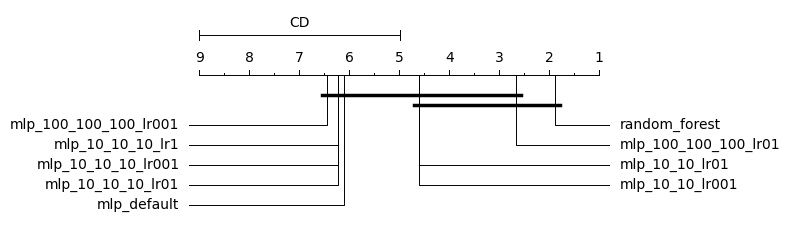

In [139]:
from autorank import autorank, plot_stats, create_report
import matplotlib.pyplot as plt

result = autorank(df_ml_metrics, alpha=0.05, verbose=False, order='ascending')
plot_stats(result)
plt.show()

At alpha = 0.05, random forest with default parameters has statistically significant better performance than other models except:
1. ANN with three hidden layers and 100 neurons each with ADAM optimiser, 0.01 initial learning rate and 500 max iterations
2. ANN with two hidden layers and 10 neurons each with ADAM optimiser, 0.01 initial learning rate and 100 max iterations
3. ANN with two hidden layers and 10 neurons each with ADAM optimiser, 0.001 initial learning rate and 100 max iterations

## Concluding remarks

The best model chosen from the analysis is random forest with default parameters with RMSE 88.410921

Support vector regression did not converge after 535m of cross validation and 175m of learning curve plot. Thus, it is not included in this analysis. Moreover, Li et al. (2009) mentioned that SVM is not suitable for very large datasets.

We conclude that for datasets with real estate attributes, random forest is the best model for price forecasting; while for time series dataset on real estate transaction price, ARIMA and SARIMAX is the best model for price forecasting.

## References
Li et al. (2009): https://ieeexplore.ieee.org/document/5178618